<a href="https://colab.research.google.com/github/vladsavelyev/deeplearning/blob/master/karpathy/makemore_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
from pathlib import Path
import requests
data_path = Path('names.txt')
if not data_path.exists():
    r = requests.get('https://raw.githubusercontent.com/vladsavelyev/deeplearning/master/karpathy/names.txt')
    with data_path.open('wb') as f:
        f.write(r.content)

with data_path.open() as f:
    words = f.read().split()

print(words[:10])
print(f'{len(words)=}, {max(len(w) for w in words)=}, {min(len(w) for w in words)=}')

vocab = ['.'] + sorted(list(set(''.join(words))))
itos = {k: v for k, v in enumerate(vocab)}
stoi = {v: k for k, v in itos.items()}
print(len(vocab), vocab)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
len(words)=32033, max(len(w) for w in words)=15, min(len(w) for w in words)=2
27 ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [65]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xtest, Ytest = build_dataset(words[n2:])  # 10%
len(Xtr), len(Xdev), len(Xtest)

(182625, 22655, 22866)

In [66]:
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(42)  # for reproducibility
C  = torch.randn((len(vocab), n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, len(vocab)),          generator=g)
b2 = torch.randn(len(vocab),                      generator=g)

parameters = [C, W1, b1, W2, b2]
print('Model parameters number', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

Model parameters number 11897


In [67]:
max_steps = 200_000
batch_size = 32
learning_rate = 0.1

lossi = []

@torch.no_grad()
def calc_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest),
    }[split]
    emb = C[x].view(-1, block_size * n_embd)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    return F.cross_entropy(logits, y)
    
for i in range(max_steps):
    lr = learning_rate
    if i > max_steps / 2:
        lr = learning_rate / 10

    # minibatch construct
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)

    # forward pass
    emb = C[Xtr[ix]].view(-1, block_size * n_embd)  # embed chars into vectors
    h = torch.tanh(emb @ W1 + b1)  # hidden layer actications
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Ytr[ix])  # loss function
    # equivalent to (assuming probs = F.softmax(logits, dim=1)):
    # loss = = F.nll_loss(probs.log(), Ytr[ix])
    # loss = -probs[torch.arange(start=0, end=len(ix)), Ytr[ix]].log().mean()

    # track stats for 1000 steps
    if i % (max_steps / 1000) == 0:
        lossi.append(calc_loss('dev'))
        # print 100 steps
        if i % (max_steps / 100) == 0:
            print(f'{i=}, {lr=}, loss_dev={lossi[-1]}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # paramter update
    for p in parameters:
        p.data -= learning_rate * p.grad

print(f'Final dev loss: {calc_loss("dev")}')
print(f'Final test loss: {calc_loss("test")}')

i=0, lr=0.1, loss_dev=26.972827911376953
i=2000, lr=0.1, loss_dev=3.054460287094116
i=4000, lr=0.1, loss_dev=2.7417726516723633
i=6000, lr=0.1, loss_dev=2.6612091064453125
i=8000, lr=0.1, loss_dev=2.600219249725342
i=10000, lr=0.1, loss_dev=2.6144962310791016
i=12000, lr=0.1, loss_dev=2.52915096282959
i=14000, lr=0.1, loss_dev=2.4970622062683105
i=16000, lr=0.1, loss_dev=2.478848934173584
i=18000, lr=0.1, loss_dev=2.450507879257202
i=20000, lr=0.1, loss_dev=2.438777208328247
i=22000, lr=0.1, loss_dev=2.473804235458374
i=24000, lr=0.1, loss_dev=2.412447929382324
i=26000, lr=0.1, loss_dev=2.4093754291534424
i=28000, lr=0.1, loss_dev=2.3998866081237793
i=30000, lr=0.1, loss_dev=2.3889992237091064
i=32000, lr=0.1, loss_dev=2.411163091659546
i=34000, lr=0.1, loss_dev=2.424211263656616
i=36000, lr=0.1, loss_dev=2.3934221267700195
i=38000, lr=0.1, loss_dev=2.3628344535827637
i=40000, lr=0.1, loss_dev=2.3427627086639404
i=42000, lr=0.1, loss_dev=2.4599416255950928
i=44000, lr=0.1, loss_dev=2.3

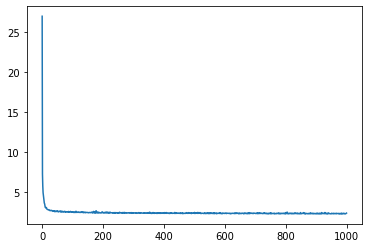

In [68]:
plt.plot([i for i in range(len(lossi))], lossi)

In [70]:
n_words = 15
g = torch.Generator().manual_seed(42)
max_word_len = 20
for _ in range(n_words):
    context = [0] * block_size
    losses = []
    for _ in range(max_word_len):
        x = torch.tensor(context[-block_size:]).view(1, block_size)
        emb = C[x].view(-1, n_embd * block_size)
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        next_char = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context.append(next_char)
        losses.append(-probs[0, next_char].log().mean().item())
        if next_char == 0:
            break
    gen_chars = context[3:]
    gen_word = ''.join(map(itos.get, gen_chars))
    print(f'{gen_word:<{max_word_len}} {sum(losses) / len(losses):.2f}')

abdanevoan.          2.45
journ.               1.77
mik.                 1.94
mar.                 1.68
aya.                 1.79
alee.                1.58
liu.                 3.30
hay.                 1.98
jayse.               1.51
mira.                1.24
khyah.               1.80
davereelyn.          1.91
julai.               2.31
jeharne.             1.94
sydn.                2.27
